# WGCNA using parameters

Below is some demonstration data, that takes the parameters for each individual fitted from a common negative binomial model (meaning they all have the same dispersion parameter). This can be probably to expression data directly. This notebook will be a tutorial about how to identify gene modules (where they can be identified).

In [ ]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append("../src")
df = pd.read_csv("../data/data.csv").set_index("specimen").drop("group", axis=1).T

# To remove those with too small of values
df = df.loc[df.min(axis=1) > -10]

In [97]:
import topology
import activation
import clustering
import correlation
import utilities

import importlib
importlib.reload(topology)
importlib.reload(utilities)
importlib.reload(activation)
importlib.reload(clustering)
importlib.reload(correlation)

<module 'correlation' from '/Users/jameshaberberger/GitHub/pywgcna/example/../src/correlation.py'>

Here, we compute the shrunk covariance matrix using the Ledoit-Wolf estimator, find the scale free power, and compute the Topological Overlap Matrix (measure of graph similarity).

In [89]:
corr = correlation.compute_shrunk_correlation(df.T)

sf_power = topology.find_scale_free_power(
    activation.strictly_positive_activation(corr)
)

TOM = pd.DataFrame(
    topology.topological_overlap(np.power(activation.strictly_positive_activation(corr), sf_power)),
    index=df.index,
    columns=df.index
)

Power: 1, R^2: 0.16026281312026605
Power: 2, R^2: 0.7896350486515918
Power: 3, R^2: 0.9614165999310181


<Axes: ylabel='Frequency'>

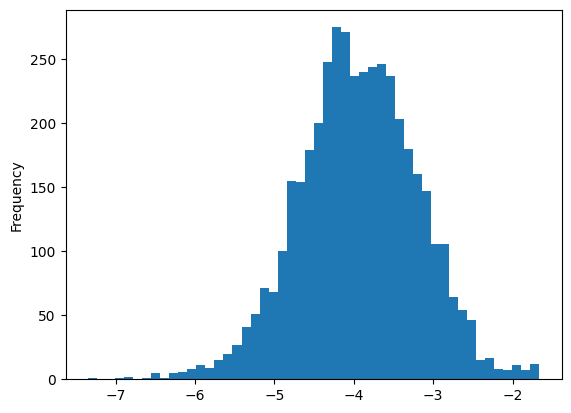

In [90]:
import sklearn.mixture

identifying_spurious_correlations = pd.DataFrame({
    "group": sklearn.mixture.GaussianMixture(n_components=2).fit_predict(pd.Series(TOM.max(axis=0), index=df.index).apply(np.log).values.reshape(-1, 1)).tolist(),
    "max_log_corr": pd.Series(TOM.max(axis=0), index=df.index).apply(np.log)
})

identifying_spurious_correlations["max_log_corr"].plot.hist(bins=50)

In [91]:
spurious_correlations = pd.Series(TOM.max(axis=0), index=df.index).apply(np.log).between(-10, -1)

TOM = TOM.loc[spurious_correlations, spurious_correlations]

In [ ]:
labels = clustering.spectral_clustering_method(TOM)
labels = sklearn.cluster.SpectralClustering(n_clusters=5).fit_predict(TOM.values)

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


<Axes: >

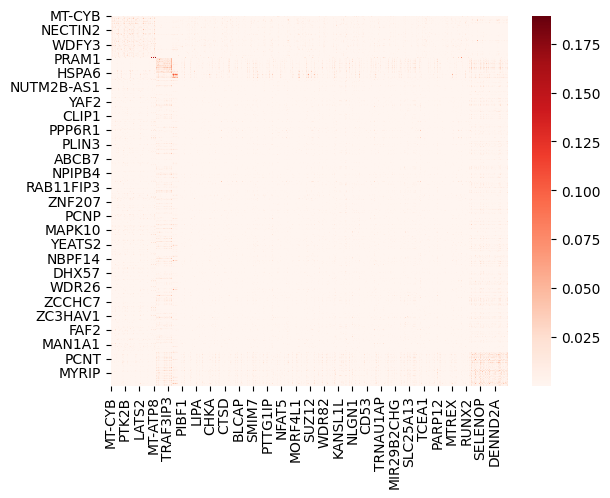

In [109]:
sns.heatmap(
    TOM.iloc[np.argsort(labels), np.argsort(labels)], 
    cmap="Reds"
)

# Plotting Correlations

In [110]:
pd.Series(labels).value_counts()

3    3158
0     481
4     396
1     173
2      64
Name: count, dtype: int64

In [121]:
print(" ".join(TOM.index[labels == 2].tolist()))

BCAS2 HSPA6 CACYBP ATF3 RANBP2 SLC20A1 NR4A2 HSPD1 CLK1 NOP58 IRAK2 RAB7A B3GNT5 TRA2B SLBP AC093895.1 SQSTM1 CD83 HSPA1A HSPA1B CDKN1A HSP90AB1 ELOVL5 HSPB1 IFRD1 RHEB INSIG1 DNAJB6 TNFRSF10B NDRG1 DNAJA1 P4HA1 BAG3 STIP1 SERPINH1 CHORDC1 HSPA8 SLC2A3 NR4A1 PTGES3 UBC USPL1 HSPH1 HSP90AA1 DNAJA4 ALPK3 IRF8 SLC7A5 USP36 ENGASE MKNK2 GADD45B LDLR DNAJB1 IFI30 NFKBID NAPA PPP1R15A NUCB1 ZNF331 CTSZ PDXK HMOX1 MSN
